Like ocr-lstm-ctc-words but with ConvTranspose2d to get more output space.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


date : Thu Sep  5 22:37:53 PDT 2019
hostname : bragi
whoami : tmb
pwd : /home/tmb/exp/icdar2019-text

[(5, 128, 368, 1), (5, 128, 528, 1), (5, 112, 368, 1), (5, 112, 576, 1), (5, 128, 464, 1)]
1.0
cuda:0


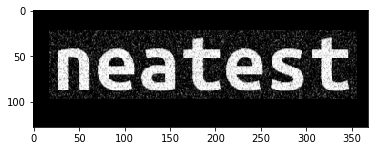

In [2]:
exec(open("startup.py").read())
images, targets, ilens, tlens = next(iter(training_dl))
imshow(images[0,:,:,0].detach().numpy())
print([tuple(sample[0].shape) for sample in islice(training_dl, 0, 5)])
print(images.max().item())
print(device)

In [6]:
!awk '/lstm_transpose/' RS="\n\n" models.py

def make_lstm_transpose(noutput=noutput):
    model = nn.Sequential(
        layers.Input("BHWD", reorder="BDHW", range=(0, 1), sizes=[None, 1, None, None]),
        *conv2x(50, 3),
        *conv2x(100, 3),
        *conv2x(150, 3),
        *conv2x(200, 3),
        layers.Fun("lambda x: x.sum(2)"), # BDHW -> BDW
        flex.ConvTranspose1d(800, 1, stride=2), # <-- undo too tight spacing
        #flex.BatchNorm1d(), nn.ReLU(),
        layers.Reorder("BDL", "LBD"),
        flex.LSTM(100, bidirectional=True),
        layers.Reorder("LBD", "BDL"),
        flex.Conv1d(noutput, 1),
        layers.Reorder("BDL", "BLD")
    )
    flex.shape_inference(model, (1, 128, 512, 1))
    return model


In [7]:
import models; reload(models)
model = models.make("lstm_transpose")
model

Sequential(
  (0): Input(BHWD->BDHW torch.float32 (0, 1) cuda:0 [None, 1, None, None])
  (1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(100, 150, kernel_size=(3, 3),

KeyboardInterrupt: 

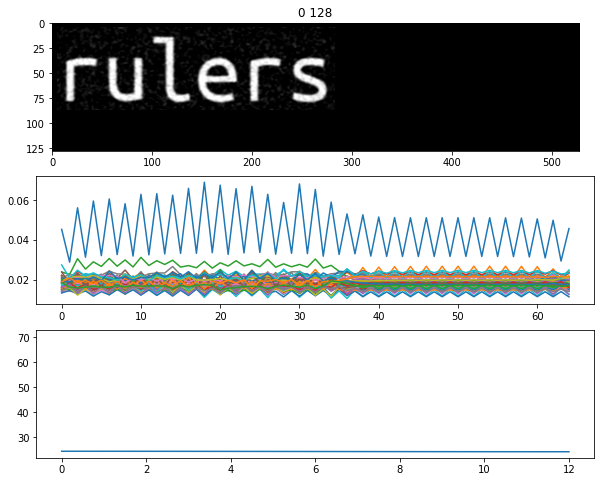

In [8]:
trainer = helpers.LineTrainer(model)
trainer.train(training_dl, 20)

In [ ]:
figsize(10, 10)
for i, batch in enumerate(islice(training_dl, 0, 10)):
    subplot(5, 2, i+1)
    result = trainer.predict_batch(*batch[:2], threshold=0.8)
    imshow(batch[0][0,:,:,0].detach().numpy())
    title(decode_str(result[0]))

In [ ]:
trainer.errors(testing_dl)